# Proyek Predictive Analytics : Klasifikasi Pencemaran Udara Jakarta

Nama  : Paramita Citra Indah Mulia

Email : paramitamulia@gmail.com

# Import library yang dibutuhkan

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from pprint import pprint

# Data Understanding

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
data = pd.read_csv('/content/drive/MyDrive/combined.csv')
data.head()

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
0,2020-08-01,DKI1 (Bunderan HI),65,18,7,84,13,84.0,O3,SEDANG,NaN
1,2020-08-02,DKI1 (Bunderan HI),75,17,11,77,15,77.0,O3,SEDANG,NaN
2,2020-08-03,DKI1 (Bunderan HI),71,18,9,65,11,71.0,PM10,SEDANG,NaN
3,2020-08-04,DKI1 (Bunderan HI),61,19,5,61,11,61.0,PM10,SEDANG,NaN
4,2020-08-05,DKI1 (Bunderan HI),67,20,7,70,12,70.0,O3,SEDANG,NaN


In [28]:
data.tail()

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
3650,2021-09-26,DKI5 (Kebon Jeruk) Jakarta Barat,48,---,4,30,9,67.0,PM25,SEDANG,67
3651,2021-09-27,DKI5 (Kebon Jeruk) Jakarta Barat,51,---,9,22,18,78.0,PM25,SEDANG,78
3652,2021-09-28,DKI5 (Kebon Jeruk) Jakarta Barat,42,---,5,26,14,64.0,PM25,SEDANG,64
3653,2021-09-29,DKI5 (Kebon Jeruk) Jakarta Barat,56,---,11,34,19,87.0,PM25,SEDANG,87
3654,2021-09-30,DKI5 (Kebon Jeruk) Jakarta Barat,68,---,10,46,13,108.0,PM25,TIDAK SEHAT,108


In [29]:
print(data.shape)

(3655, 11)


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   3655 non-null   object 
 1   stasiun   3655 non-null   object 
 2   pm10      3655 non-null   object 
 3   so2       3655 non-null   object 
 4   co        3655 non-null   object 
 5   o3        3655 non-null   object 
 6   no2       3655 non-null   object 
 7   max       3651 non-null   float64
 8   critical  3623 non-null   object 
 9   categori  3655 non-null   object 
 10  pm25      1763 non-null   object 
dtypes: float64(1), object(10)
memory usage: 314.2+ KB


Fitur-fitur pada data:

1. tanggal : Tanggal pengukuran kualitas udara
2. stasiun : Lokasi pengukuran di stasiun
3. pm10 : Partikulat salah satu parameter yang diukur
4. pm25 : Partikulat salah satu parameter yang diukur
5. so2 : Sulfida (dalam bentuk SO2) salah satu parameter yang diukur
6. co : Carbon Monoksida salah satu parameter yand diukur
7. o3 : Ozon salah satu parameter yang diukur
8. no2 : NItrogen dioksida salah satu parameter yang diukur
9. max : Nilai ukur paling tinggi dari seluruh parameter yang diukur dalam waktu yang sama
10. critical : Parameter yang hasil pengukurannya paling tinggi
11. categori : Kategori hasil perhitungan indeks standar pencemaran udara

**EDA**

1. Jumlah data per kategori

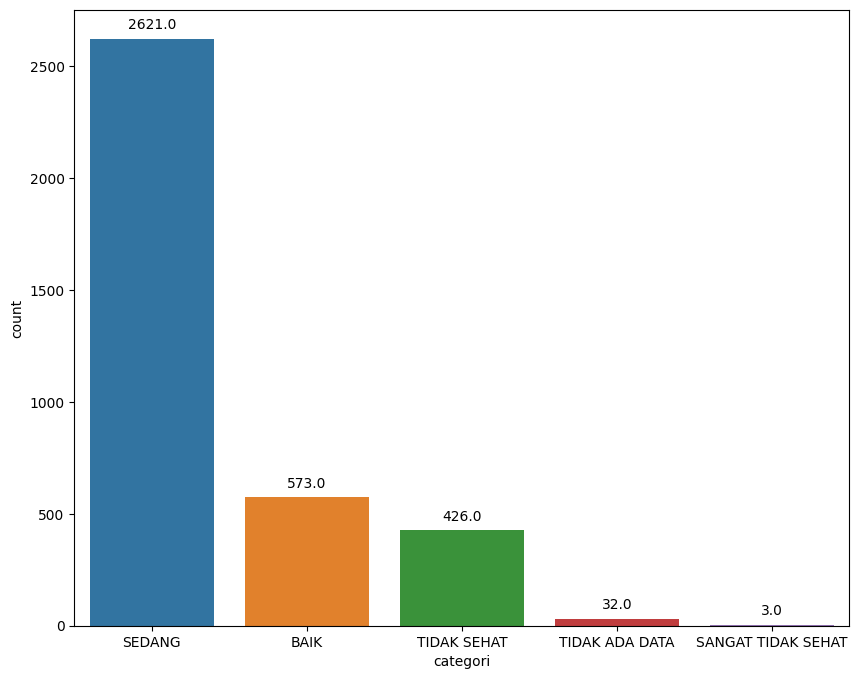

In [31]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='categori', data=data)

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

terdapat 5 kategori yaitu sedang, baik, tidak sehat, sangat tidak sehat, dan tidak ada data. Kategori 'tidak ada data' akan dihapus, dan karena jumlah data dengan kategori sangat tidak sehat hanya 3, maka pada klasifikasi ini hanya akan digunakan tiga kategori saja yaitu sedang, baik, dan tidak sehat.

2. Persebaran Kategori Kualitas Udara di 5 Stasiun

In [32]:
data['stasiun'].value_counts()

DKI1 (Bunderan HI)                  700
DKI3 (Jagakarsa)                    700
DKI4 (Lubang Buaya)                 700
DKI5 (Kebon Jeruk) Jakarta Barat    700
DKI2 (Kelapa Gading)                700
43                                   10
40                                    8
54                                    8
34                                    8
44                                    7
50                                    6
51                                    6
45                                    6
48                                    5
53                                    5
56                                    5
62                                    4
59                                    4
65                                    4
58                                    4
49                                    3
47                                    3
32                                    3
39                                    3
52                                    3


Data terbanyak yaitu masing-masing 700 data adalah data dari stasiun DKI1 (Bunderan HI), DKI5 (Kebon Jeruk) Jakarta Barat, DKI4 (Lubang Buaya), DKI3 (Jagakarsa), DKI2 (Kelapa Gading). Sedangkan data paling sedikit dengan jumlah hanya 1 data berasal dari stasiun dengan kode 63, 57, 24, 64, 73, 89, 101, 60, 41, 76, 61, dan 25.

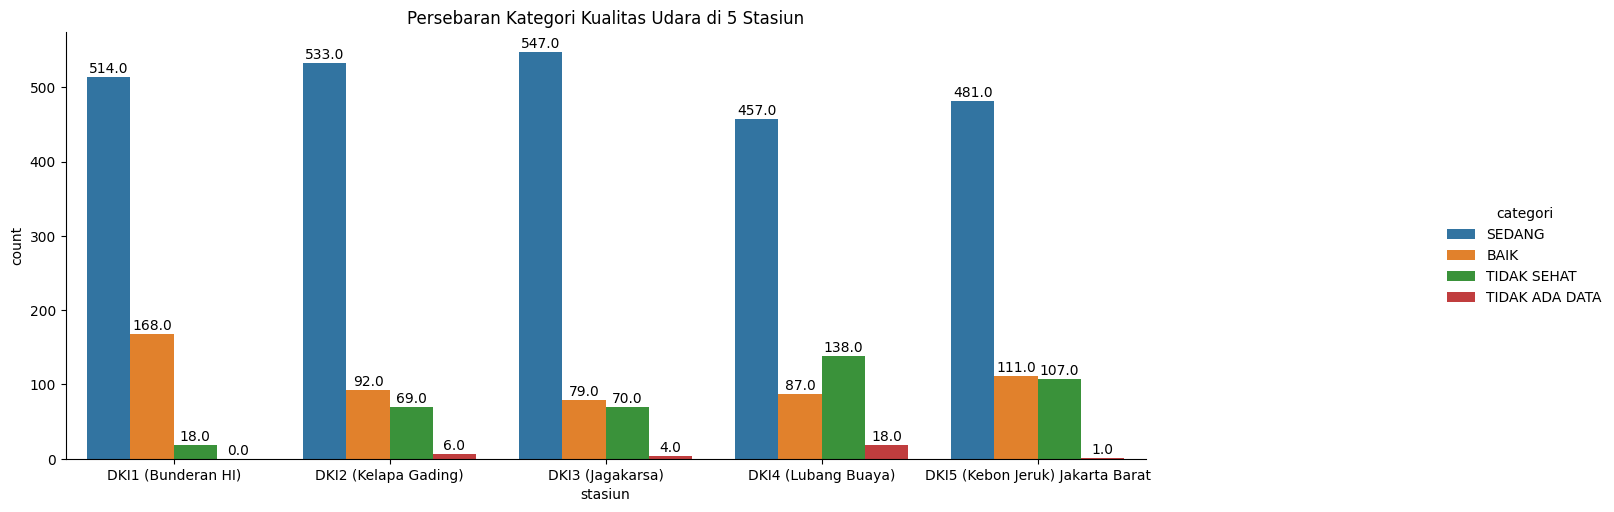

In [33]:
#Persebaran Kategori Kualitas Udara di 5 Stasiun Terbanyak
selected_stations = ["DKI1 (Bunderan HI)", "DKI5 (Kebon Jeruk) Jakarta Barat", "DKI4 (Lubang Buaya)", "DKI3 (Jagakarsa)", "DKI2 (Kelapa Gading)"]
filtered_data = data[data['stasiun'].isin(selected_stations)]

catplot = sns.catplot(x='stasiun', hue='categori', kind='count', data=filtered_data)
catplot.fig.set_size_inches(18, 5)

for ax in catplot.axes.flat:
    for bar in ax.patches:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 2,
            round(bar.get_height(), 2),
            ha='center',
            va='bottom'
        )

plt.title('Persebaran Kategori Kualitas Udara di 5 Stasiun')
plt.show()

Stasiun Lubang Buaya merupakan daerah dengan indeks udara tidak sehat terbanyak dan Bunderan HI adalah yang paling sedikit.

Sementara itu, seluruh stasiun memiliki kategori sedang yang hampir sama dengan terbanyak adalah stasiun Jagakarsa

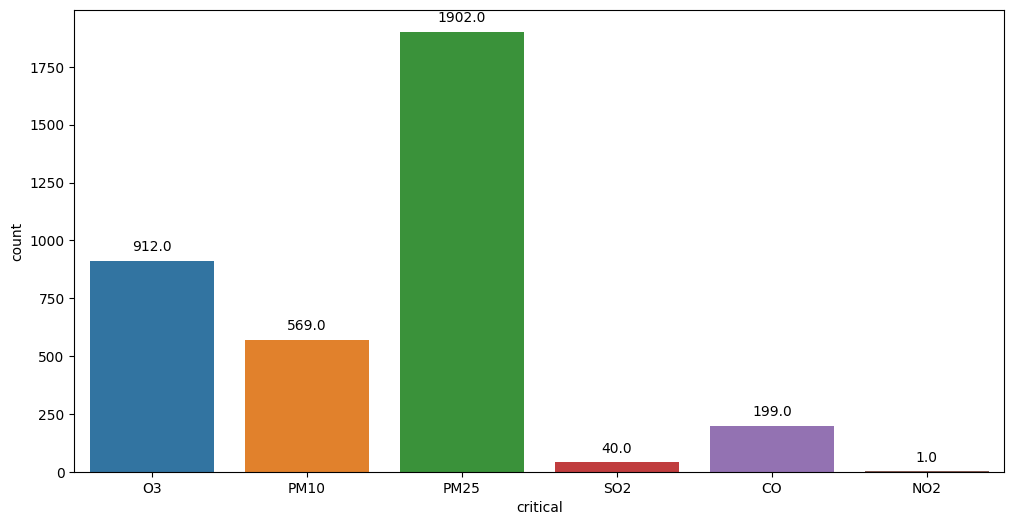

In [90]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='critical', data=data)

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

Parameter dengan hasil pengukuran tertinggi terbanyak adalah PM25. Menurut Kementerian Lingkungan Hidup dan Kehutanan, parameter PM2,5 merupakan parameter pencemar udara paling berpengaruh terhadap kesehatan manusia.

# Data Preparation

In [42]:
#definisi data dengan 3 kategori yang telah ditetapkan
data2 = data[~data['categori'].isin(['SANGAT TIDAK SEHAT', 'TIDAK ADA DATA'])]

In [43]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3654
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   3620 non-null   object 
 1   stasiun   3620 non-null   object 
 2   pm10      3620 non-null   object 
 3   so2       3620 non-null   object 
 4   co        3620 non-null   object 
 5   o3        3620 non-null   object 
 6   no2       3620 non-null   object 
 7   max       3620 non-null   float64
 8   critical  3620 non-null   object 
 9   categori  3620 non-null   object 
 10  pm25      1749 non-null   object 
dtypes: float64(1), object(10)
memory usage: 339.4+ KB


Data pm25 hanya sejumlah 1749 dari 3620 data,
berdasarkan domain knowledge bahwa pm25 merupakan parameter pencemar udara paling berpengaruh terhadap kesehatan, data yang akan digunakan adalah data yang memiliki pm25 non-nul.

In [44]:
data_br = data2[data2['pm25'].notnull()]
data_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 155 to 3654
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   1749 non-null   object 
 1   stasiun   1749 non-null   object 
 2   pm10      1749 non-null   object 
 3   so2       1749 non-null   object 
 4   co        1749 non-null   object 
 5   o3        1749 non-null   object 
 6   no2       1749 non-null   object 
 7   max       1749 non-null   float64
 8   critical  1749 non-null   object 
 9   categori  1749 non-null   object 
 10  pm25      1749 non-null   object 
dtypes: float64(1), object(10)
memory usage: 164.0+ KB


In [45]:
data_br.isnull().sum()

tanggal     0
stasiun     0
pm10        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
pm25        0
dtype: int64

melihat apakah masih ada missing value berbentuk lain

In [46]:
cols_with_nan_or_dash = data_br.columns[data_br.isin([np.nan, '---']).any()].tolist()
print(cols_with_nan_or_dash)

['pm10', 'so2', 'co', 'o3', 'no2', 'pm25']


Terdapat missing value pada variabel 'pm10', 'so2', 'co', 'o3', 'no2', 'pm25'.
Pada variabel numerik ini, mv akan diisi dengan nilai mean.

In [47]:
# Mengganti '---' dengan NaN
data_br = data_br.replace('---', np.nan)

# Mengisi NaN dengan mean pada kolom numerik
for kolom in ['pm10', 'so2', 'co', 'o3', 'no2', 'max', 'pm25']:
    data_br[kolom] = data_br[kolom].astype(float).fillna(data_br[kolom].astype(float).mean())

In [48]:
columns_with_dash = [col for col in data_br.columns if (data_br[col] == '---').any()]
print(columns_with_dash)

[]


cek data duplikat

In [49]:
data_br.duplicated().sum()

0

tidak ada data duplikat, missing value dan data duplikat berhasil ditangani.

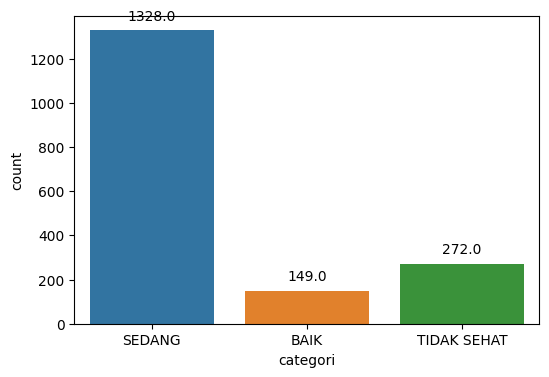

In [50]:
#melihat jumlah data pada masing-masing kategori setelah dilakukan preprocessing
#melihat jumlah categori
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='categori', data=data_br)

# Tambahkan jumlah data di atas setiap bar
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

melihat jumlah data yang ada, akan digunakan 200 data kategori sedang, 149 kategori baik, dan 200 data kategori tidak sehat.

In [60]:
# Mengambil 200 data dengan kategori 'sedang'
df_sedang = data_br[data_br['categori'] == 'SEDANG'].head(200)

# Mengambil semua data dengan kategori 'baik'
df_baik = data_br[data_br['categori'] == 'BAIK']

# Mengambil 200 data dengan kategori 'tidak sehat'
df_tidak_sehat = data_br[data_br['categori'] == 'TIDAK SEHAT'].head(200)

# Menggabungkan ketiga DataFrame tersebut
df_mod = pd.concat([df_sedang, df_baik, df_tidak_sehat])

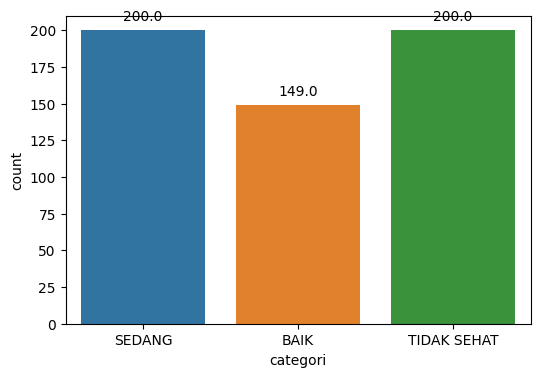

In [61]:
#melihat jumlah data pada masing-masing kategori setelah dilakukan preprocessing
#melihat jumlah categori
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='categori', data=df_mod)

# Tambahkan jumlah data di atas setiap bar
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

In [62]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 155 to 2390
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   549 non-null    object 
 1   stasiun   549 non-null    object 
 2   pm10      549 non-null    float64
 3   so2       549 non-null    float64
 4   co        549 non-null    float64
 5   o3        549 non-null    float64
 6   no2       549 non-null    float64
 7   max       549 non-null    float64
 8   critical  549 non-null    object 
 9   categori  549 non-null    object 
 10  pm25      549 non-null    float64
dtypes: float64(7), object(4)
memory usage: 51.5+ KB


kolom critical dan categori masih dalam bentuk objek. pada kedua kolom akan dilakukan pelabelan dengan LabelEncoder.

In [63]:
#pelabelan dengan label encoder
label_mappings = {}
le = LabelEncoder()

for column in ['stasiun', 'critical', 'categori']:
    df_mod[column] = le.fit_transform(df_mod[column])

    label_mappings[column] = dict(zip(le.classes_, range(len(le.classes_))))

pprint(label_mappings)

{'categori': {'BAIK': 0, 'SEDANG': 1, 'TIDAK SEHAT': 2},
 'critical': {'O3': 0, 'PM10': 1, 'PM25': 2, 'SO2': 3},
 'stasiun': {'DKI1 (Bunderan HI)': 0,
             'DKI2 (Kelapa Gading)': 1,
             'DKI3 (Jagakarsa)': 2,
             'DKI4 (Lubang Buaya)': 3,
             'DKI5 (Kebon Jeruk) Jakarta Barat': 4}}


In [65]:
df_mod.head(5)

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
155,2021-08-01,0,51.0,25.0,8.0,29.0,22.0,68.0,2,1,68.0
156,2021-08-02,0,47.0,24.0,10.0,25.0,28.0,63.0,2,1,63.0
157,2021-08-03,0,50.0,26.0,11.0,19.0,35.0,68.0,2,1,68.0
158,2021-08-04,0,52.0,29.0,8.0,24.0,26.0,70.0,2,1,70.0
159,2021-08-05,0,52.0,29.0,9.0,21.0,27.0,66.0,2,1,66.0


In [66]:
df_mod2 = df_mod.drop('tanggal', axis=1)
df_mod2.head(5)

,stasiun,pm10,so2,co,o3,no2,max,critical,categori,pm25
155,0,51.0,25.0,8.0,29.0,22.0,68.0,2,1,68.0
156,0,47.0,24.0,10.0,25.0,28.0,63.0,2,1,63.0
157,0,50.0,26.0,11.0,19.0,35.0,68.0,2,1,68.0
158,0,52.0,29.0,8.0,24.0,26.0,70.0,2,1,70.0
159,0,52.0,29.0,9.0,21.0,27.0,66.0,2,1,66.0


In [69]:
#normalisasi data
standard_scaler = StandardScaler()
df_standard = standard_scaler.fit_transform(df_mod2)
df_standard

array([[-1.36097939, -0.39172773, -0.81240762, ...,  0.14593725,
        -0.11731115, -0.14647923],
       [-1.36097939, -0.50984123, -0.89584107, ...,  0.14593725,
        -0.11731115, -0.34771292],
       [-1.36097939, -0.42125611, -0.72897418, ...,  0.14593725,
        -0.11731115, -0.14647923],
       ...,
       [ 0.78402832, -0.21455749,  0.93969481, ...,  0.14593725,
         1.14550883,  1.18166315],
       [ 0.78402832,  0.11025462,  0.68939446, ...,  0.14593725,
         1.14550883,  2.06709141],
       [ 0.78402832,  0.11025462,  0.85626136, ...,  0.14593725,
         1.14550883,  2.14758489]])

In [70]:
# Membagi data menjadi training set dan test set
X = df_mod[['stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'pm25', 'critical']]
y = df_mod['categori']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Development

Algoritma 1 : Random Forest

In [77]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Akurasi Random Forest:", accuracy_score(y_test, rf_predictions))

Akurasi Random Forest: 0.9818181818181818


Algoritma 2 : SVM

In [75]:
# KNN
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print("Akurasi KNN:", accuracy_score(y_test, knn_predictions))

Akurasi KNN: 0.8818181818181818


# Evaluation

In [78]:
# Buat dataframe berisikan score masing-masing algoritma dari data train dan test
score = pd.DataFrame()

# buat dictionary untuk setiap algoritma yang digunakan
model_dict = {'RF': rf, 'KNN': knn}

# hitung f1-score masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
  score.loc[name, 'train'] = f1_score(y_train, y_pred=model.predict(X_train), average='weighted')
  score.loc[name, 'test'] = f1_score(y_test, y_pred=model.predict(X_test), average='weighted')

# Panggil score
score

,train,test
RF,1.000000,0.982087
KNN,0.943156,0.882195


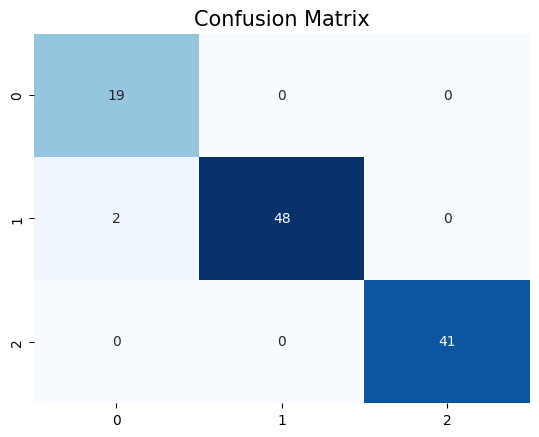

In [79]:
# hitung confusion matrix dari data testing
cnf_matrix = confusion_matrix(y_test, rf_predictions)

# Plot confusion matrix
sns.heatmap(cnf_matrix, annot=True, cbar=False, cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [82]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.96      0.98        50
           2       1.00      1.00      1.00        41

    accuracy                           0.98       110
   macro avg       0.97      0.99      0.98       110
weighted avg       0.98      0.98      0.98       110



In [83]:
prediksi = X_test[:5].copy()
pred_dict = {'y_true':y_test[:5]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)

pd.DataFrame(pred_dict)

,y_true,prediksi_RF,prediksi_KNN
547,1,1,1
242,1,1,1
1789,2,2,2
291,1,1,2
1783,2,2,2
